The dataset used to conduct this experiment was obtained from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).
To be able run this notebook locally download the dataset from the link provided and delete the `.DS_Store` files.

# Motivation
The implementation of clinical-decision support algorithms for medical imaging faces challenges with reliability and interpretability. Here, we establish a diagnostic tool based on a deep-learning framework for the screening of patients with common treatable blinding retinal diseases. Our framework utilizes transfer learning, which trains a neural network with a fraction of the data of conventional approaches. Applying this approach to a dataset of optical coherence tomography images, we demonstrate performance comparable to that of human experts in classifying age-related macular degeneration and diabetic macular edema. We also provide a more transparent and interpretable diagnosis by highlighting the regions recognized by the neural network. We further demonstrate the general applicability of our AI system for diagnosis of pediatric pneumonia using chest X-ray images. This tool may ultimately aid in expediting the diagnosis and referral of these treatable conditions, thereby facilitating earlier treatment, resulting in improved clinical outcomes.
Text preluated from [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

# Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [1]:
# Setup
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow import keras

import IPython.display as display
from PIL import Image

In [2]:
# PATHS
_PATH = os.getcwd()
_DATASET = os.path.join(_PATH, "chest_xray")
_TRAINING_DATA = os.path.join(_DATASET, "train")
_TESTING_DATA = os.path.join(_DATASET, "test") 
_VAL_DATA = os.path.join(_DATASET, "val") 

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# memory fix
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# INSPECT THE DATASET

In [4]:
training = pathlib.Path(_TRAINING_DATA)
training_data_length = len(list(training.glob('*/*.jpeg')))

testing = pathlib.Path(_TESTING_DATA)
testing_data_length = len(list(testing.glob('*/*.jpeg')))

val = pathlib.Path(_VAL_DATA)
val_data_length = len(list(val.glob('*/*.jpeg')))

CLASS_NAMES = np.array([item.name for item in training.glob('*') if item.name != ".DS_Store"])

print(f"IDENTIFIED CLASSES: {CLASS_NAMES}")
print(f"TRAINING: {training_data_length}")
print(f"TESTING: {testing_data_length}")
print(f"VAL: {val_data_length}")

IDENTIFIED CLASSES: ['NORMAL' 'PNEUMONIA']
TRAINING: 5216
TESTING: 624
VAL: 16


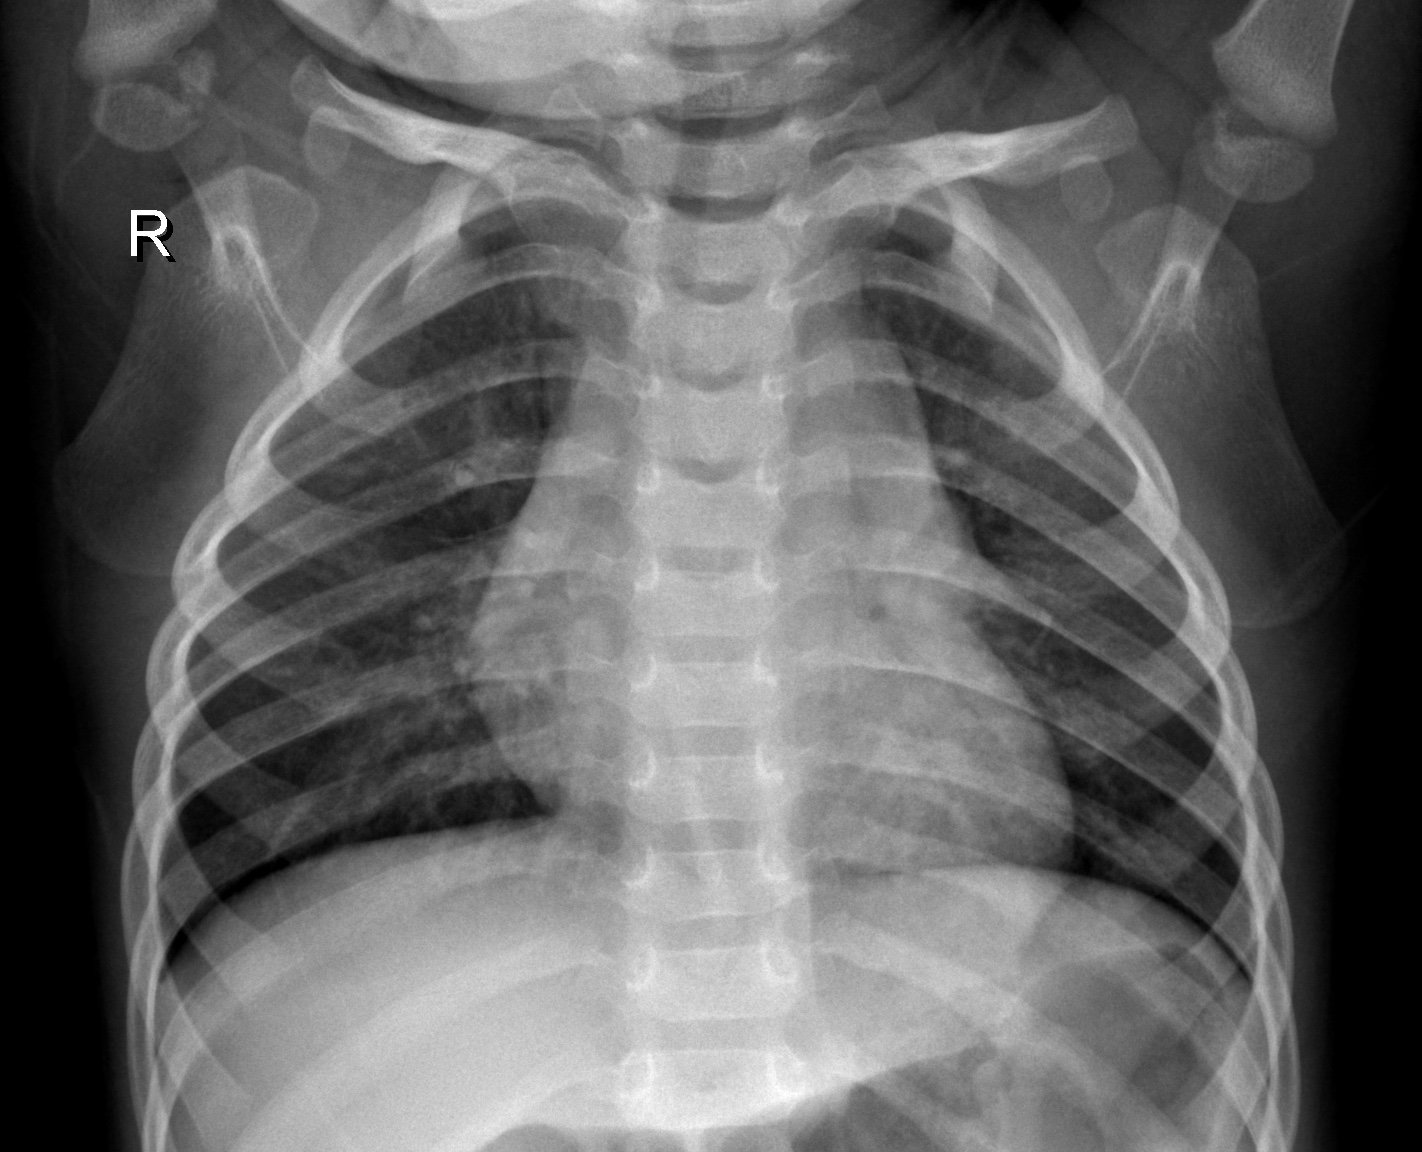

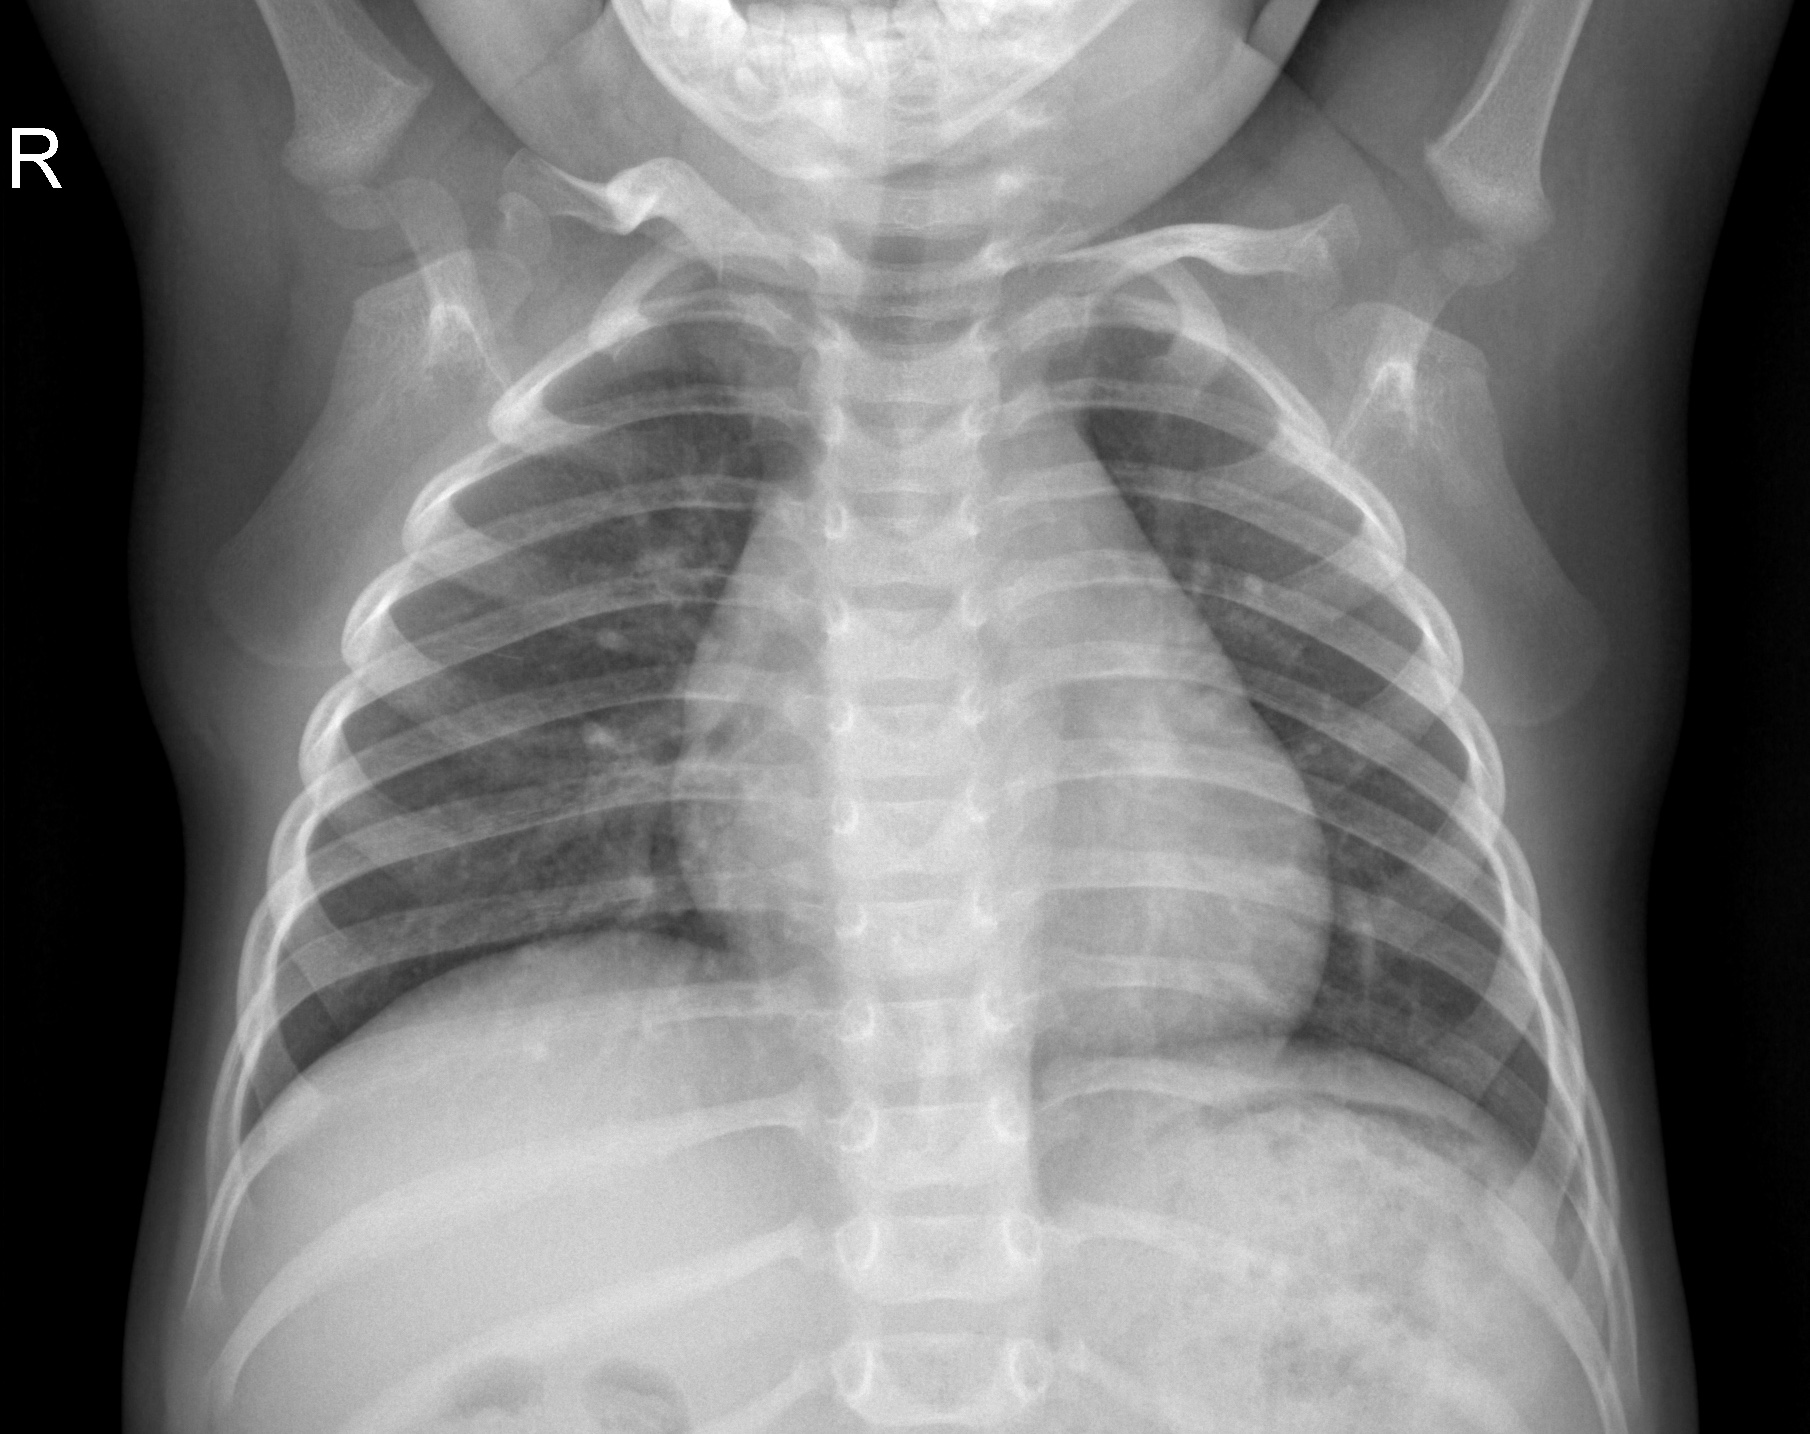

In [5]:
pics = list(training.glob('NORMAL/*'))

for image_path in pics[1:3]:
    display.display(Image.open(str(image_path)))

The 1./255 is to convert from uint8 to float32 in range [0,1].

In [6]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# BATCH CONFIG

In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(training_data_length/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(testing_data_length/BATCH_SIZE)

In [8]:
train_data_gen = image_generator.flow_from_directory(directory=str(training),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 5216 images belonging to 2 classes.


### EXAMINE BATCH

In [9]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

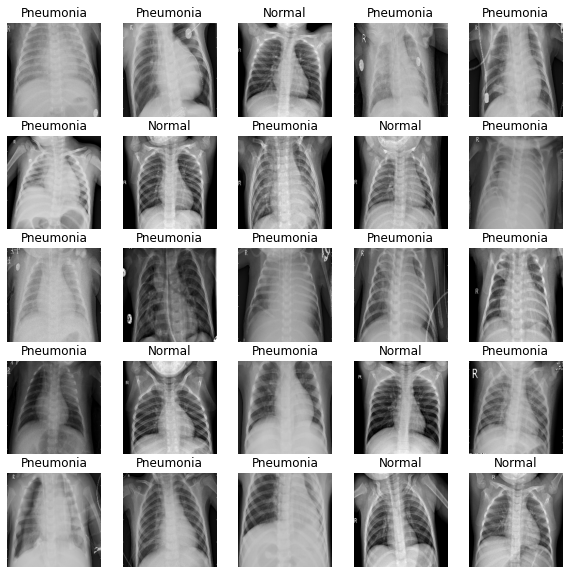

In [10]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Loading data
To load the files as a `tf.data.Dataset` first create the datasets of the file paths:

In [11]:
list_training_ds = tf.data.Dataset.list_files(str(training/'*/*'))
list_testing_ds = tf.data.Dataset.list_files(str(testing/'*/*'))
list_eval_ds = tf.data.Dataset.list_files(str(val/'*/*'))

In [12]:
for f in list_training_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Terkea\\Desktop\\pneumoniaX-RAY\\chest_xray\\train\\PNEUMONIA\\person382_bacteria_1741.jpeg'
b'C:\\Users\\Terkea\\Desktop\\pneumoniaX-RAY\\chest_xray\\train\\PNEUMONIA\\person1310_bacteria_3302.jpeg'
b'C:\\Users\\Terkea\\Desktop\\pneumoniaX-RAY\\chest_xray\\train\\PNEUMONIA\\person281_bacteria_1328.jpeg'
b'C:\\Users\\Terkea\\Desktop\\pneumoniaX-RAY\\chest_xray\\train\\PNEUMONIA\\person654_bacteria_2546.jpeg'
b'C:\\Users\\Terkea\\Desktop\\pneumoniaX-RAY\\chest_xray\\train\\NORMAL\\NORMAL2-IM-1132-0001.jpeg'


A short pure-tensorflow function that converts a file path to an `(img, label)` pair:

In [13]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [14]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [15]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Used `Dataset.map` to create a datasets of `image, label` pairs

Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

In [55]:
labeled_training_ds = list_training_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_testing_ds = list_testing_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_eval_ds = list_eval_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
for image, label in labeled_training_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]


## Basic methods for training
To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.
* These features can be easily added using the tf.data api.

This is a small dataset, only load it once, and keep it in memory.
use `.cache(filename)` to cache preprocessing work for datasets that don't
it in memory.

In [56]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [19]:
train_ds = prepare_for_training(labeled_training_ds)
train_data, train_labels = next(iter(train_ds))

In [20]:
test_ds = prepare_for_training(labeled_testing_ds)
test_data, test_labels = next(iter(test_ds))

In [21]:
eval_ds = prepare_for_training(labeled_testing_ds)
eval_data, eval_labels = next(iter(eval_ds))

## Create the model
The architecture used was inspiered from the following articles:
* [Convolutional Neural Network Architecture: Forging Pathways to the Future](https://missinglink.ai/guides/convolutional-neural-networks/convolutional-neural-network-architecture-forging-pathways-future/)
* [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

Whereas throughout the journey I been experimenting with multiple optimization strategies to identify the optimal parameters, the ones that you see here are the ones who performed the best.

In [23]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(3000, activation='relu'),
    keras.layers.Dense(2000, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(2, activation="softmax")
])

model.compile(optimizer='adam',
            loss="categorical_crossentropy",
            metrics=['accuracy'])

To prevent the model from overfitting we attached an `EarlyStopping` callback which stops training when a monitored metric has stopped improving (accuracy)

`patience` -	Number of epochs with no improvement after which training will be stopped.

`Tensorboard` callback added for benchmarking

In [24]:
logdir = "logs\\training\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


model.fit(train_ds, 
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=100,
      validation_data=test_ds,
      validation_steps=VALIDATION_STEPS,
      callbacks=[callback, tensorboard_callback])

Train for 163.0 steps, validate for 20.0 steps
Epoch 1/100
163/163 [==============================] - 39s 242ms/step - loss: 0.3912 - accuracy: 0.9034 - val_loss: 1.0104 - val_accuracy: 0.7063
Epoch 2/100
163/163 [==============================] - 22s 133ms/step - loss: 0.1018 - accuracy: 0.9634 - val_loss: 1.0999 - val_accuracy: 0.7250
Epoch 3/100
163/163 [==============================] - 22s 135ms/step - loss: 0.0733 - accuracy: 0.9739 - val_loss: 1.4304 - val_accuracy: 0.7250
Epoch 4/100
163/163 [==============================] - 22s 133ms/step - loss: 0.0519 - accuracy: 0.9797 - val_loss: 1.9538 - val_accuracy: 0.7281
Epoch 5/100
163/163 [==============================] - 22s 138ms/step - loss: 0.0398 - accuracy: 0.9843 - val_loss: 2.5316 - val_accuracy: 0.7047
Epoch 6/100
163/163 [==============================] - 23s 139ms/step - loss: 0.0269 - accuracy: 0.9891 - val_loss: 2.7519 - val_accuracy: 0.7109
Epoch 7/100
163/163 [==============================] - 22s 134ms/step - loss:

In [25]:
test_loss, test_acc = model.evaluate(test_ds, steps=VALIDATION_STEPS, verbose=2)

20/20 - 1s - loss: 2.0681 - accuracy: 0.7406


# Make predictions


In [50]:
# make predictions based on the first batch of eval dataset
first_batch_of_tests = eval_ds.take(1)
predictions = model.predict(first_batch_of_tests)

In [54]:
image_batch, label_batch = tf.data.experimental.get_single_element(first_batch_of_tests)
predicted_labels = [np.argmax(item) for item in predictions]

In [52]:
def show_predictions(image_batch, true_labels, predicted_labels):
    plt.figure(figsize=(13,13))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if(predicted_labels[n] == np.argmax(true_labels[n])):
            color = 'blue'
        else:
            color = 'red'
        plt.axis('off')
        plt.title(f"{CLASS_NAMES[predicted_labels[n]]}", color=color)

20/20 - 1s - loss: 2.1699 - accuracy: 0.7391


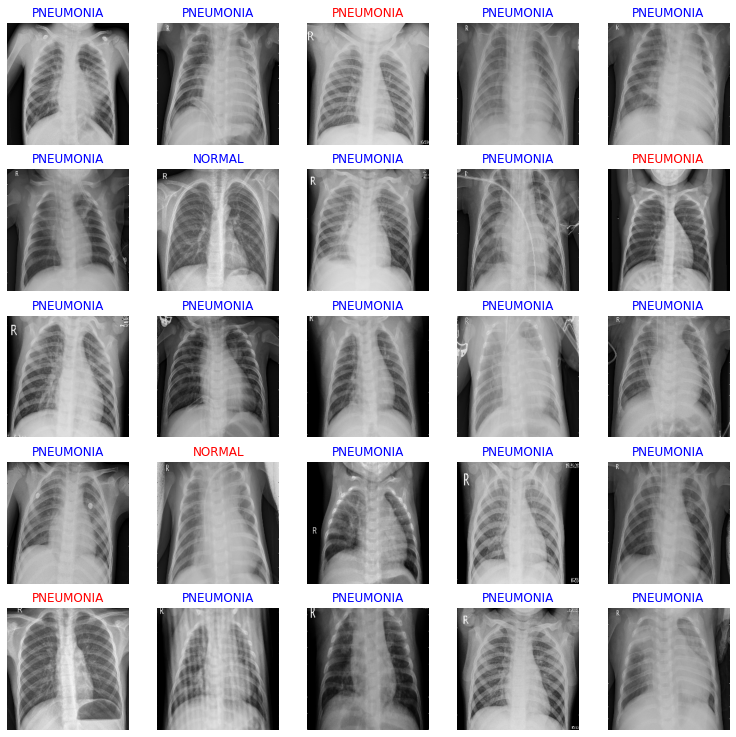

In [53]:
show_predictions(image_batch, label_batch, predicted_labels)
test_loss, test_acc = model.evaluate(eval_ds, steps=VALIDATION_STEPS, verbose=2)